In [3]:
import pandas as pd
import pandas_datareader.data as web
import datetime

# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)

print(apple.head())

                  Open        High         Low       Close    Volume  \
Date                                                                   
2016-01-04  102.610001  105.370003  102.000000  105.349998  67649400   
2016-01-05  105.750000  105.849998  102.410004  102.709999  55791000   
2016-01-06  100.559998  102.370003   99.870003  100.699997  68457400   
2016-01-07   98.680000  100.129997   96.430000   96.449997  81094400   
2016-01-08   98.550003   99.110001   96.760002   96.959999  70798000   

             Adj Close  
Date                    
2016-01-04  102.612183  
2016-01-05  100.040792  
2016-01-06   98.083025  
2016-01-07   93.943473  
2016-01-08   94.440222  


In [4]:
import matplotlib.pyplot as plt   # Import matplotlib

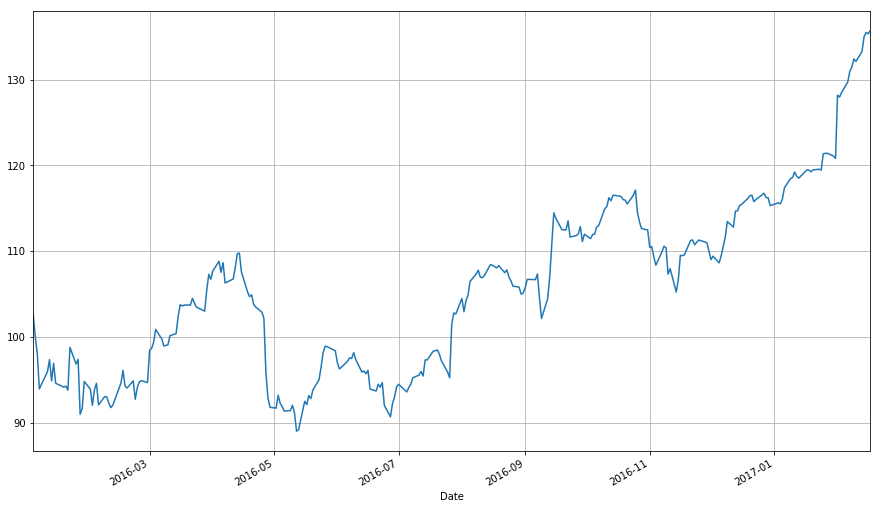

Populating the interactive namespace from numpy and matplotlib


In [5]:
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

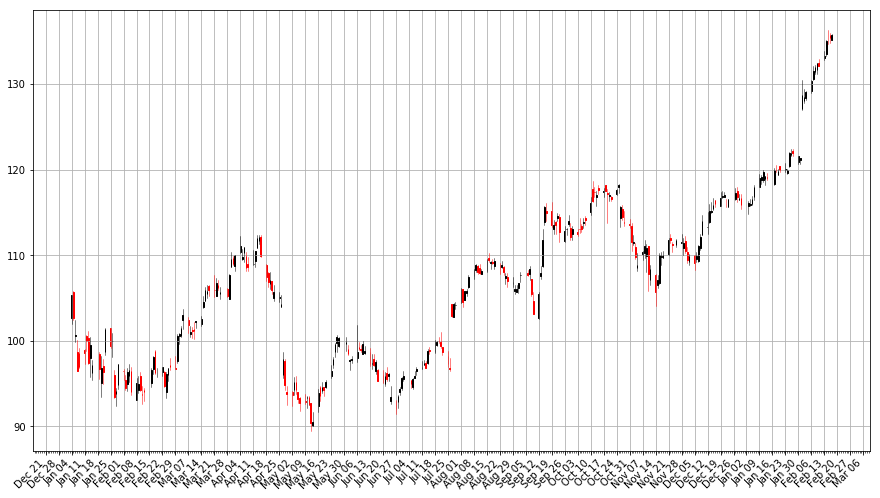

In [6]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

In [7]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

                  AAPL        GOOG       MSFT
Date                                         
2016-01-04  102.612183  741.840027  53.015032
2016-01-05  100.040792  742.580017  53.256889
2016-01-06   98.083025  743.619995  52.289462
2016-01-07   93.943473  726.390015  50.470697
2016-01-08   94.440222  714.469971  50.625489

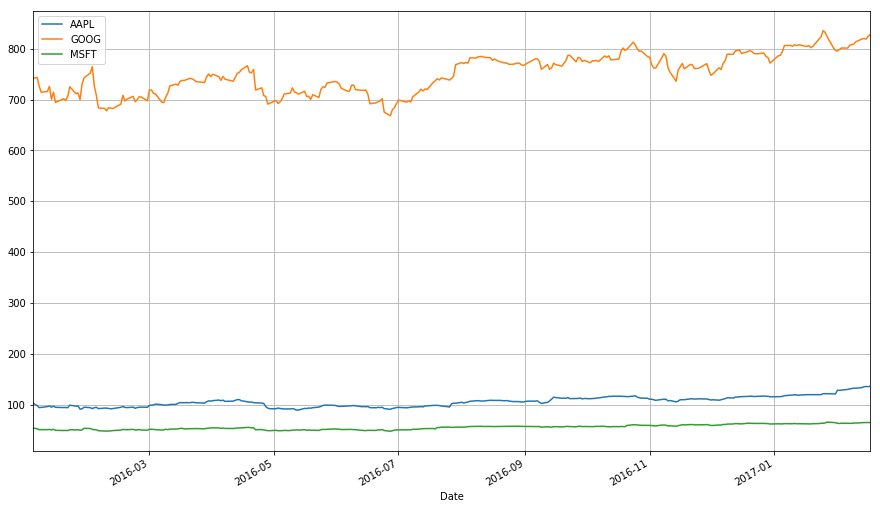

In [8]:
stocks.plot(grid = True)

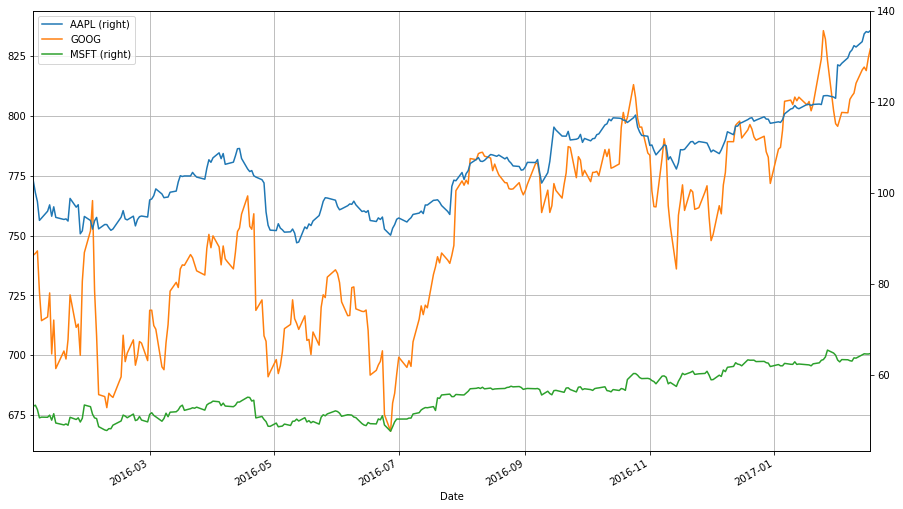

In [9]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [10]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

                AAPL      GOOG      MSFT
Date                                    
2016-01-04  1.000000  1.000000  1.000000
2016-01-05  0.974941  1.000998  1.004562
2016-01-06  0.955861  1.002399  0.986314
2016-01-07  0.915520  0.979173  0.952007
2016-01-08  0.920361  0.963105  0.954927

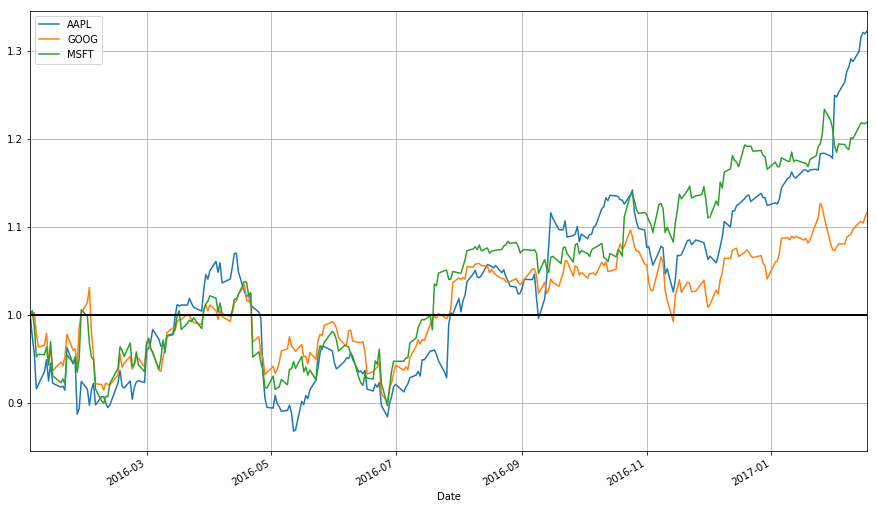

In [11]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [12]:
import numpy as np

stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.head()

                AAPL      GOOG      MSFT
Date                                    
2016-01-04       NaN       NaN       NaN
2016-01-05 -0.025379  0.000997  0.004552
2016-01-06 -0.019764  0.001400 -0.018332
2016-01-07 -0.043121 -0.023443 -0.035402
2016-01-08  0.005274 -0.016546  0.003062

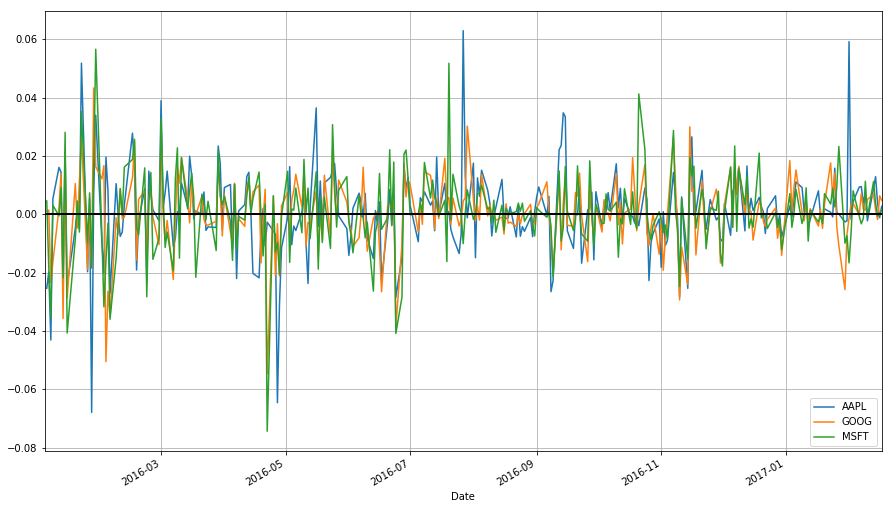

In [13]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

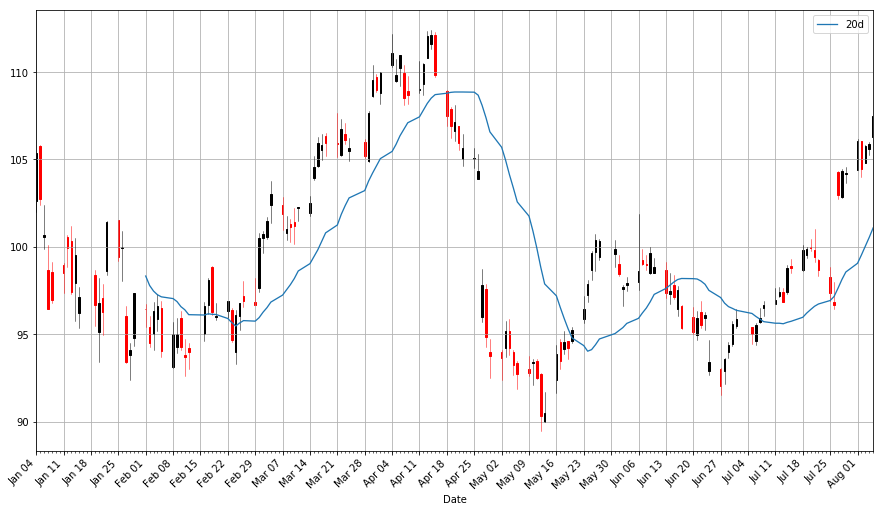

In [14]:
apple['20d'] = np.round(apple['Close'].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = '20d')

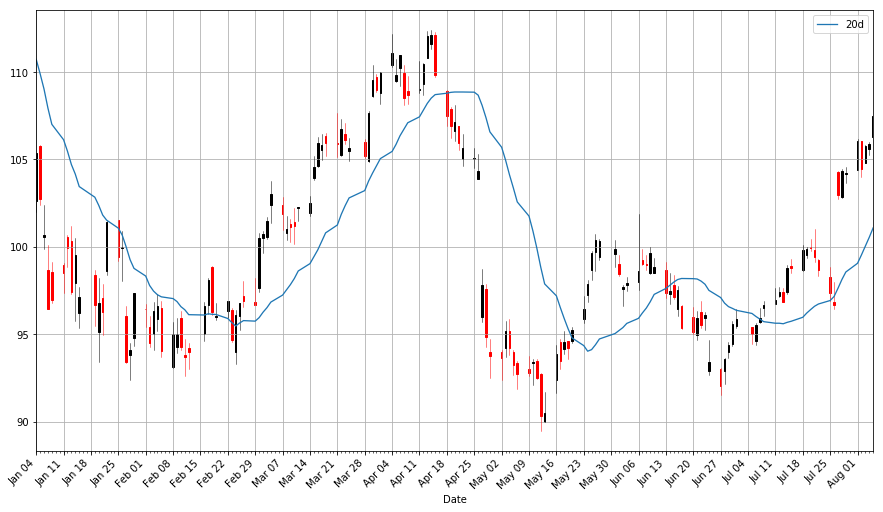

In [15]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

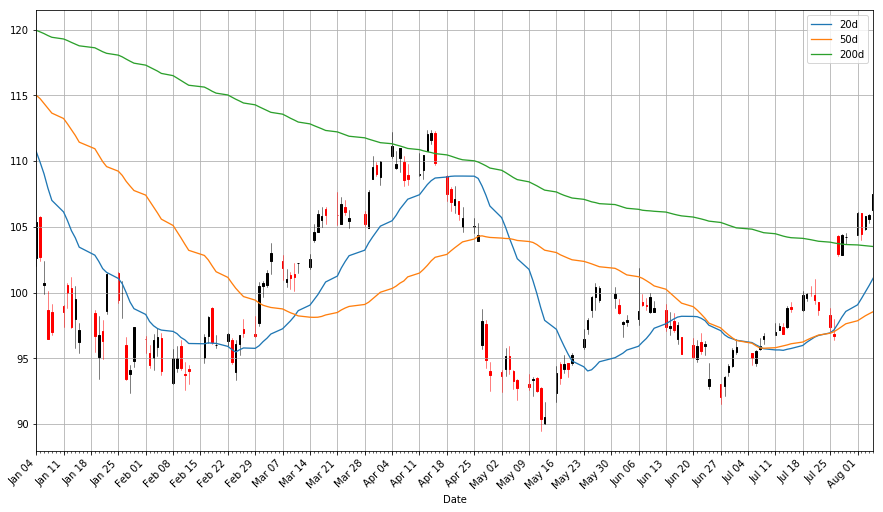

In [16]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

In [17]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()


                  Open        High         Low       Close    Volume  \
Date                                                                   
2017-02-13  133.080002  133.820007  132.750000  133.289993  23035400   
2017-02-14  133.470001  135.089996  133.250000  135.020004  32815500   
2017-02-15  135.520004  136.270004  134.619995  135.509995  35501600   
2017-02-16  135.669998  135.899994  134.839996  135.350006  22118000   
2017-02-17  135.100006  135.830002  135.100006  135.720001  22084500   

             Adj Close     20d     50d    200d  20d-50d  
Date                                                     
2017-02-13  133.289993  125.33  119.41  108.51     5.92  
2017-02-14  135.020004  126.08  119.92  108.72     6.16  
2017-02-15  135.509995  126.86  120.43  108.93     6.43  
2017-02-16  135.350006  127.64  120.96  109.13     6.68  
2017-02-17  135.720001  128.42  121.47  109.34     6.95  

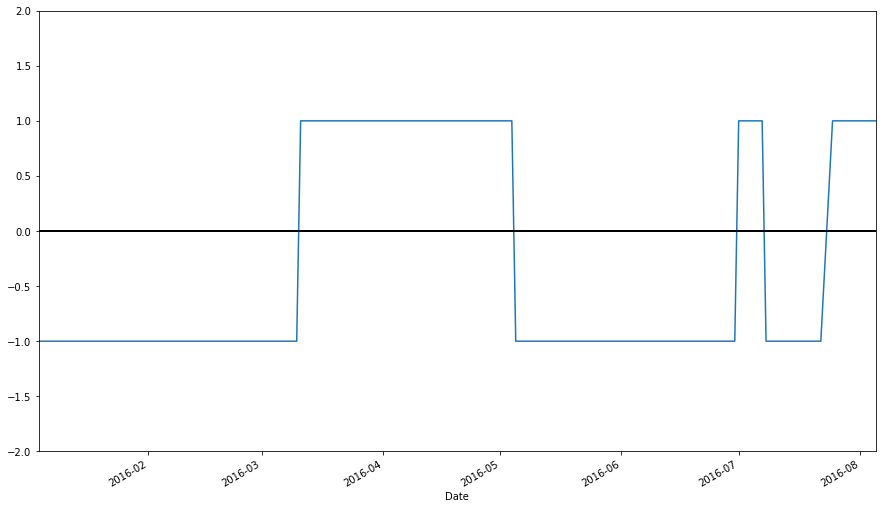

In [18]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

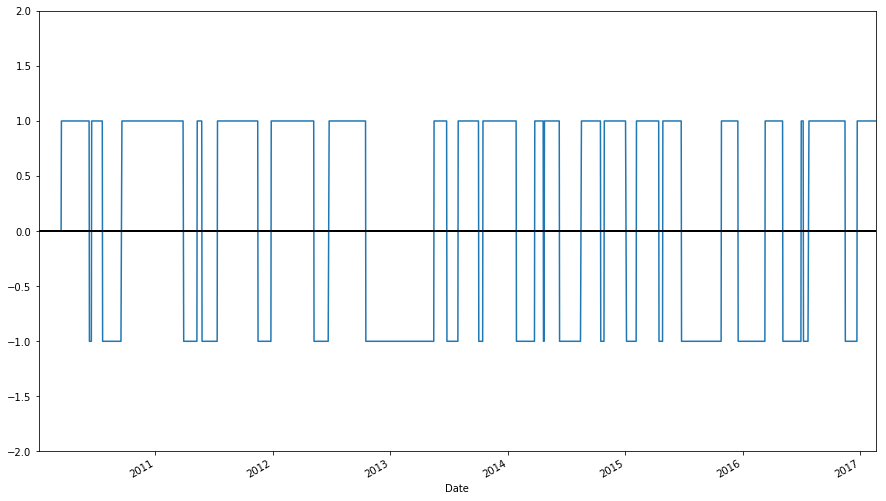

In [19]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [20]:
apple["Regime"].value_counts()

 1    1056
-1     689
 0      50
Name: Regime, dtype: int64

In [21]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

                  Open        High         Low       Close    Volume  \
Date                                                                   
2017-02-13  133.080002  133.820007  132.750000  133.289993  23035400   
2017-02-14  133.470001  135.089996  133.250000  135.020004  32815500   
2017-02-15  135.520004  136.270004  134.619995  135.509995  35501600   
2017-02-16  135.669998  135.899994  134.839996  135.350006  22118000   
2017-02-17  135.100006  135.830002  135.100006  135.720001  22084500   

             Adj Close     20d     50d    200d  20d-50d  Regime  Signal  
Date                                                                     
2017-02-13  133.289993  125.33  119.41  108.51     5.92     1.0     0.0  
2017-02-14  135.020004  126.08  119.92  108.72     6.16     1.0     0.0  
2017-02-15  135.509995  126.86  120.43  108.93     6.43     1.0     0.0  
2017-02-16  135.350006  127.64  120.96  109.13     6.68     1.0     0.0  
2017-02-17  135.720001  128.42  121.47  109.34     

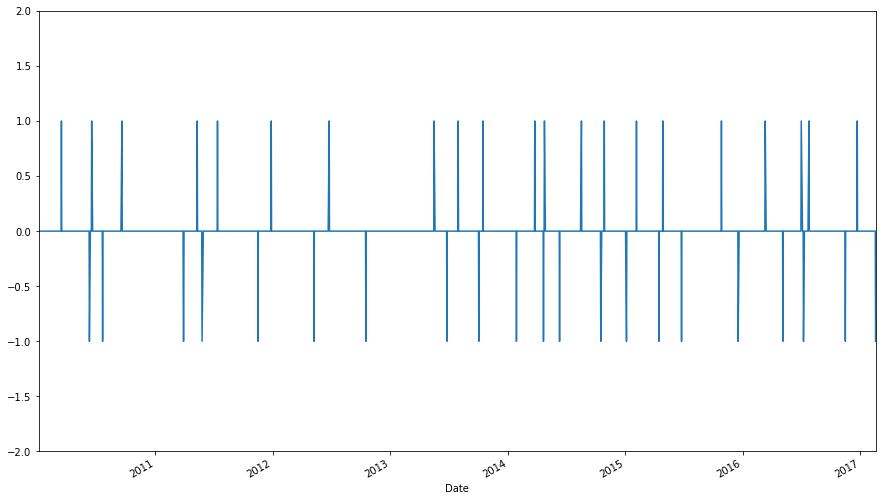

In [22]:
apple["Signal"].plot(ylim = (-2, 2))

In [23]:
apple["Signal"].value_counts()

 0.0    1751
-1.0      22
 1.0      21
Name: Signal, dtype: int64